# Himalayan Fault-Bend Fold: Earthquake Cycle Decomposition

Smooth C2 fault geometry → dislocation network → structural/elastic decomposition → river profile.

**Sign convention (fixed):**
- Each segment stores `slip_u1` and `slip_u2`: the pre-signed slip for the horizontal and vertical displacement kernels.
- Fault segments: `slip_u1 = slip_u2 = −fault_slip` (thrust convention).
- Fold segments: `slip_u1 = +fold_slip`, `slip_u2 = −fold_slip`.
- Structural velocity: `u = s cos θ`, `v = −s sin θ` (θ from `arctan2(dz, dx)`, z positive up).

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
import cmocean.cm as cmc

mpl.rcParams["figure.dpi"] = 1000
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "stix",
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

## Edge dislocation kernels

Surface displacement from a 2-D edge dislocation at depth `d` with signed Burgers vector `slip`.
A finite fault/fold segment is two edge dislocations of opposite sign at the endpoints.

In [10]:
def u1_edge(x_obs, slip, delta, d, x_ref, orient):
    """Horizontal surface displacement from one edge dislocation."""
    if d <= 0:
        eps = 1e-12
        return -(slip / np.pi) * np.cos(delta) * np.arctan2(
            orient * (x_obs - x_ref), eps)
    zeta = orient * (x_obs - x_ref) / d
    return -(slip / np.pi) * (
        np.cos(delta) * np.arctan(zeta)
        - (np.sin(delta) - zeta * np.cos(delta)) / (1.0 + zeta**2))


def u2_edge(x_obs, slip, delta, d, x_ref, orient):
    """Vertical surface displacement from one edge dislocation."""
    if d <= 0:
        eps = 1e-12
        return -(slip / np.pi) * np.sin(delta) * np.arctan2(
            orient * (x_obs - x_ref), eps)
    zeta = orient * (x_obs - x_ref) / d
    return -(slip / np.pi) * (
        np.sin(delta) * np.arctan(zeta)
        + (np.cos(delta) + zeta * np.sin(delta)) / (1.0 + zeta**2))


def u1_segment(x_obs, x1, z1, x2, z2, signed_slip):
    """Horizontal displacement from a finite segment.
    signed_slip: pre-signed Burgers vector at the shallow endpoint."""
    d1, d2 = -z1, -z2
    dx, dd = x2 - x1, d2 - d1
    delta = np.arctan2(abs(dd), max(abs(dx), 1e-12))
    orient = np.sign(dx) if abs(dx) > 0 else 1.0
    if d1 <= d2:
        x_top, d_top, x_bot, d_bot = x1, d1, x2, d2
    else:
        x_top, d_top, x_bot, d_bot = x2, d2, x1, d1
    return (u1_edge(x_obs, signed_slip, delta, d_top, x_top, orient)
            + u1_edge(x_obs, -signed_slip, delta, d_bot, x_bot, orient))


def u2_segment(x_obs, x1, z1, x2, z2, signed_slip):
    """Vertical displacement from a finite segment.
    signed_slip: pre-signed Burgers vector at the shallow endpoint."""
    d1, d2 = -z1, -z2
    dx, dd = x2 - x1, d2 - d1
    delta = np.arctan2(abs(dd), max(abs(dx), 1e-12))
    orient = np.sign(dx) if abs(dx) > 0 else 1.0
    if d1 <= d2:
        x_top, d_top, x_bot, d_bot = x1, d1, x2, d2
    else:
        x_top, d_top, x_bot, d_bot = x2, d2, x1, d1
    return (u2_edge(x_obs, signed_slip, delta, d_top, x_top, orient)
            + u2_edge(x_obs, -signed_slip, delta, d_bot, x_bot, orient))

## Geometry helpers

In [11]:
def segment_angles(xnode, znode):
    dx = np.diff(xnode)
    dz = np.diff(znode)
    return np.arctan2(dz, dx), dx, dz


def compute_axial_surface_intersections(xnode, znode, theta):
    xnode = np.asarray(xnode, float)
    znode = np.asarray(znode, float)
    theta = np.asarray(theta, float)
    nseg = theta.size
    x_axial = np.empty(nseg - 1, dtype=float)
    gamma = np.empty(nseg - 1, dtype=float)
    for j in range(1, nseg):
        th1, th2 = theta[j - 1], theta[j]
        g = 0.5 * (th1 + th2 + np.pi)
        gamma[j - 1] = g
        xk, zk = xnode[j], znode[j]
        tg = np.tan(g)
        x_axial[j - 1] = np.nan if np.isclose(tg, 0.0, atol=1e-12) else xk - zk / tg
    return x_axial, gamma

## C2 fault smoothing + arc-length resampling

In [12]:
def _quintic_patch_coeffs(xL, zL, mL, xR, zR, mR):
    h = xR - xL
    a0, a1, a2 = zL, mL * h, 0.0
    D0 = zR - zL - a1
    D1 = (mR - mL) * h
    A = np.array([[1, 1, 1], [3, 4, 5], [6, 12, 20]], dtype=float)
    a3, a4, a5 = np.linalg.solve(A, [D0, D1, 0.0])
    return np.array([a0, a1, a2, a3, a4, a5], dtype=float), h


def _eval_quintic(x, xL, coeffs, h):
    t = (x - xL) / h
    a0, a1, a2, a3, a4, a5 = coeffs
    return (((((a5*t + a4)*t + a3)*t + a2)*t + a1)*t + a0)


def build_c2_fault_model(x, z, w=5.0):
    x, z = np.asarray(x, float), np.asarray(z, float)
    m_seg = np.diff(z) / np.diff(x)
    n = len(x)
    wv = np.zeros(n)
    for i in range(1, n - 1):
        wv[i] = min(float(w), 0.45 * (x[i] - x[i-1]), 0.45 * (x[i+1] - x[i]))
    patches = {}
    for i in range(1, n - 1):
        if wv[i] <= 0:
            continue
        xL, xR = x[i] - wv[i], x[i] + wv[i]
        mL, mR = m_seg[i-1], m_seg[i]
        zL = z[i] + mL * (xL - x[i])
        zR = z[i] + mR * (xR - x[i])
        coeffs, h = _quintic_patch_coeffs(xL, zL, mL, xR, zR, mR)
        patches[i] = (xL, coeffs, h)
    pieces = []
    for seg in range(n - 1):
        lc = wv[seg] if seg > 0 else 0.0
        rc = wv[seg + 1] if seg + 1 < n - 1 else 0.0
        xL, xR = x[seg] + lc, x[seg + 1] - rc
        if xR > xL:
            pieces.append(("line", xL, xR, seg))
        v = seg + 1
        if 1 <= v <= n - 2 and wv[v] > 0:
            pieces.append(("patch", x[v] - wv[v], x[v] + wv[v], v))
    return dict(x=x, z=z, m_seg=m_seg, pieces=pieces, patches=patches)


def eval_c2_fault(xq, model, extrapolate=True):
    x, z = model["x"], model["z"]
    m_seg, pieces, patches = model["m_seg"], model["pieces"], model["patches"]
    xq = np.asarray(xq, float)
    zq = np.full_like(xq, np.nan)
    for kind, xL, xR, idx in pieces:
        mask = (xq >= xL) & (xq <= xR)
        if not np.any(mask):
            continue
        if kind == "line":
            zq[mask] = z[idx] + m_seg[idx] * (xq[mask] - x[idx])
        else:
            xL0, coeffs, h = patches[idx]
            zq[mask] = _eval_quintic(xq[mask], xL0, coeffs, h)
    if extrapolate:
        zq = np.where(np.isnan(zq) & (xq < x[0]),  z[0]  + m_seg[0]  * (xq - x[0]),  zq)
        zq = np.where(np.isnan(zq) & (xq > x[-1]), z[-1] + m_seg[-1] * (xq - x[-1]), zq)
    return zq


def resample_equal_arclength(x_dense, z_dense, npts):
    ds = np.sqrt(np.diff(x_dense)**2 + np.diff(z_dense)**2)
    s = np.concatenate(([0.0], np.cumsum(ds)))
    L = s[-1]
    s_uniform = np.linspace(0, L, npts)
    return np.interp(s_uniform, s, x_dense), np.interp(s_uniform, s, z_dense), s_uniform, L

## Dislocation network and velocity functions

**Fixed sign convention:** each segment stores `slip_u1` and `slip_u2` (pre-signed).
No separate `sign_u1/sign_u2` parameters needed at call time.

**Three axial surface models** (controlled by `axial_mode`):
- `"hard"`: fold is coseismic if **both** adjacent fault segments are locked; otherwise fold slip = 0 (binary partition)
- `"half"`: fold slip = average of adjacent fault slips → smooth taper at the lock/creep boundary (neighbor-average)
- `"full"`: **all** fold segments carry the full structural fold slip, regardless of locking (fully coseismic)

In [13]:
def build_dislocation_network(xnode, znode, x_axial, theta, slip_fault,
                               include_folds=True, axial_mode="half"):
    """Build fault + fold dislocation segments with pre-signed slips.

    Parameters
    ----------
    axial_mode : {"hard", "half", "full"}
        How fold (axial surface) slip is assigned:
        - "hard"  : fold slip = structuralslip if both adjacent faults are locked,
                     else 0 (binary)
        - "half"  : fold slip uses average of adjacent fault slips (smooth taper)
        - "full"  : fold slip always uses structuralslip (all folds in coseismic)

    Returns list of dicts with x1,z1,x2,z2, slip_u1, slip_u2, kind.
    """
    xnode = np.asarray(xnode, float)
    znode = np.asarray(znode, float)
    theta = np.asarray(theta, float)
    x_axial = np.asarray(x_axial, float)
    nseg = theta.size
    if np.isscalar(slip_fault):
        slip_fault = np.full(nseg, float(slip_fault))
    else:
        slip_fault = np.asarray(slip_fault, float)

    segments = []

    # Fault segments: slip_u1 = slip_u2 = -fault_slip  (thrust convention)
    for i in range(nseg):
        s = slip_fault[i]
        segments.append(dict(
            name=f'Fault_{i+1}', kind='fault',
            x1=xnode[i], z1=znode[i], x2=xnode[i+1], z2=znode[i+1],
            slip_u1=-s, slip_u2=-s))

    # Fold (axial surface) segments
    if include_folds and nseg >= 2:
        for j in range(1, nseg):
            xa = x_axial[j - 1]
            if not np.isfinite(xa):
                continue
            dtheta = theta[j] - theta[j - 1]

            # Determine fold slip magnitude based on axial_mode
            if axial_mode == "hard":
                # Binary: fold active only if BOTH adjacent fault segments are locked
                if slip_fault[j - 1] > 0 and slip_fault[j] > 0:
                    slip_local = slip_fault[j - 1]  # both locked → use full slip
                else:
                    slip_local = 0.0
            elif axial_mode == "half":
                # Neighbor-average: smooth transition at lock/creep boundary
                slip_local = 0.5 * (slip_fault[j - 1] + slip_fault[j])
            elif axial_mode == "full":
                # All folds carry structural slip regardless of locking
                slip_local = max(slip_fault[j - 1], slip_fault[j])
                if slip_local == 0:
                    slip_local = 0.0  # only zero if neither neighbor has slip
            else:
                raise ValueError(f"Unknown axial_mode: {axial_mode!r}")

            sf = 2.0 * slip_local * np.sin(0.5 * dtheta)
            segments.append(dict(
                name=f'Axial_{j}', kind='fold',
                x1=xa, z1=0.0, x2=xnode[j], z2=znode[j],
                slip_u1=+sf, slip_u2=-sf))

    return segments


def elastic_velocity_from_segments(x_obs, segments):
    """Sum displacement from all segments using pre-signed slips."""
    U1 = np.zeros_like(x_obs)
    U2 = np.zeros_like(x_obs)
    for seg in segments:
        U1 += u1_segment(x_obs, seg['x1'], seg['z1'], seg['x2'], seg['z2'], seg['slip_u1'])
        U2 += u2_segment(x_obs, seg['x1'], seg['z1'], seg['x2'], seg['z2'], seg['slip_u2'])
    return U1, U2


def structural_velocity(x_obs, theta, x_axial, slip_by_segment, x_start):
    """Kinematic block velocity: u = s cos θ, v = -s sin θ."""
    x_obs = np.asarray(x_obs, float)
    theta = np.asarray(theta, float)
    slip_by_segment = np.asarray(slip_by_segment, float)
    x_bounds = x_axial[np.isfinite(x_axial)]
    dom = np.clip(np.searchsorted(x_bounds, x_obs, side='right'), 0, theta.size - 1)
    u = slip_by_segment[dom] * np.cos(theta[dom])
    v = -slip_by_segment[dom] * np.sin(theta[dom])
    mask = x_obs < x_start
    u, v = u.astype(float, copy=True), v.astype(float, copy=True)
    u[mask] = 0.0
    v[mask] = 0.0
    return u, v, dom

## Setup: Himalayan fault geometry

In [33]:
# Observation grid
x_master = np.linspace(1e-1, 100.0, 1000)

# Fault control points
xctrl = [0, 50, 100]
zctrl = [0,-20,-20]
w_blend = 8       # quintic blending half-width (km)
npts = 3       # resampled nodes

structuralslip = 20.0  # long-term slip rate (mm/yr)
sliprate = 20.0        # back-slip rate on locked segments

# Build smooth C2 fault and resample
model = build_c2_fault_model(xctrl, zctrl, w=w_blend)
x_dense = np.linspace(xctrl[0], xctrl[-1], 1000)
z_dense = eval_c2_fault(x_dense, model)
xnode, znode, s_uniform, L = resample_equal_arclength(x_dense, z_dense, npts)

nseg = len(xnode) - 1
theta, _, _ = segment_angles(xnode, znode)
x_axial, _ = compute_axial_surface_intersections(xnode, znode, theta)

print(f"Smooth fault: {nseg} segments, arc length = {L:.1f} km")
print(f"Depth range: {-znode.min():.1f} km")

Smooth fault: 2 segments, arc length = 103.7 km
Depth range: 20.0 km


## Earthquake cycle decomposition — 3 axial models

- **Structural** = full long-term kinematic velocity (all segments at `structuralslip`)
- **Elastic** = dislocation field from locked segments + fold contribution (depends on `axial_mode`)
- **Interseismic** = structural − elastic

Three axial surface treatments:
1. **Hard**: fold slip is binary — full if both neighbors locked, zero otherwise
2. **Half**: fold slip = neighbor-average (smooth taper at lock/creep boundary)
3. **Full**: all folds carry structural fold slip regardless of locking

In [34]:
# Locking: first n_locked segments carry back-slip
n_locked = 1
n_locked = max(0, min(n_locked, nseg))

slip_fault = np.zeros(nseg, dtype=float)
slip_fault[:n_locked] = sliprate

# Structural velocity (full long-term, all segments at structuralslip)
slip_struct = structuralslip * np.ones_like(theta)
u_struct, v_struct, _ = structural_velocity(
    x_master, theta, x_axial, slip_struct, x_start=xnode[0])

# Run all 3 axial models
axial_modes = ["hard", "half", "full"]
results = {}

for mode in axial_modes:
    segs = build_dislocation_network(
        xnode, znode, x_axial, theta, slip_fault,
        include_folds=True, axial_mode=mode)
    U1, U2 = elastic_velocity_from_segments(x_master, segs)
    inter_u = u_struct - U1
    inter_v = v_struct - U2
    results[mode] = dict(U1=U1, U2=U2, inter_u=inter_u, inter_v=inter_v, segs=segs)
    print(f"[{mode:5s}]  locked={n_locked}/{nseg}, "
          f"lock depth={-znode[n_locked]:.1f} km, "
          f"max Δv={inter_v.max():.2f} mm/yr, "
          f"n_segs={len(segs)}")

[hard ]  locked=1/2, lock depth=19.0 km, max Δv=10.26 mm/yr, n_segs=3
[half ]  locked=1/2, lock depth=19.0 km, max Δv=8.32 mm/yr, n_segs=3
[full ]  locked=1/2, lock depth=19.0 km, max Δv=6.56 mm/yr, n_segs=3


## Plot: 3 axial models compared

Top: coseismic vertical velocity (elastic). Middle: interseismic vertical velocity. Bottom: fault geometry.
Both velocity panels show the common structural field in black.

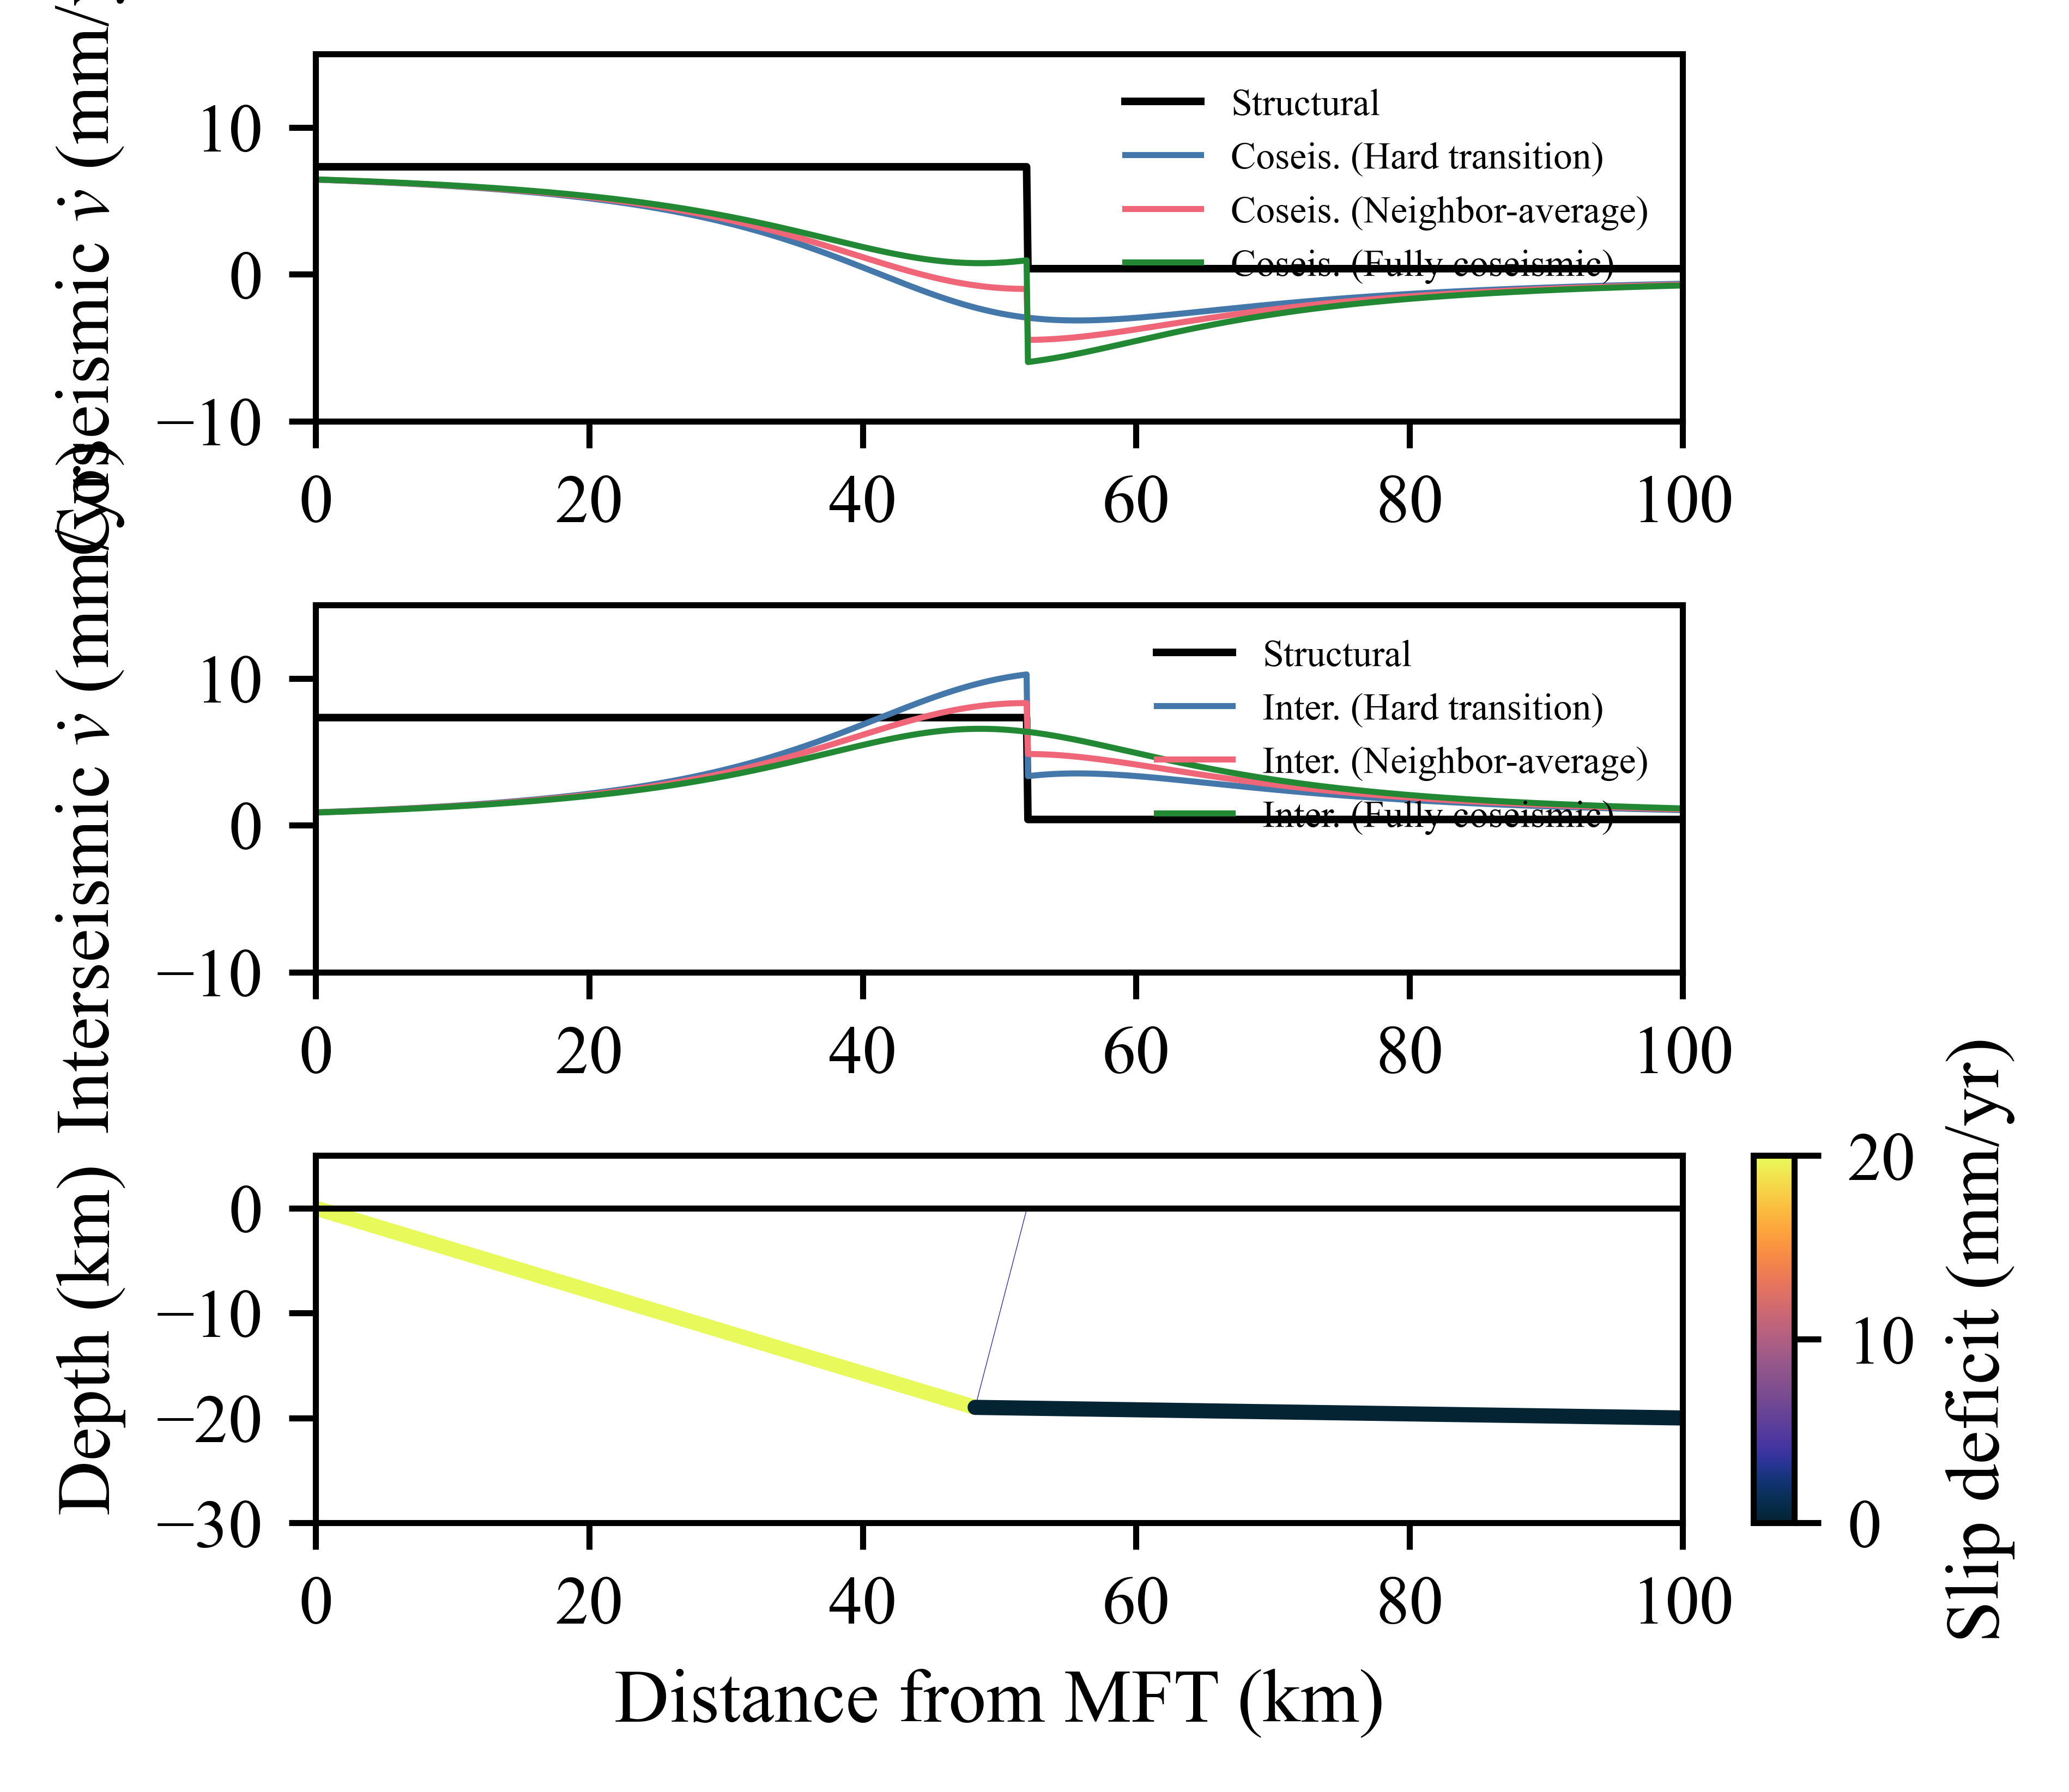

In [35]:
mode_colors = {"hard": "#4477AA", "half": "#EE6677", "full": "#228833"}
mode_labels = {"hard": "Hard transition", "half": "Neighbor-average", "full": "Fully coseismic"}

fig = plt.figure(figsize=(3.5, 3.5))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 0.03],
                      height_ratios=[1, 1, 1], hspace=0.5, wspace=0.1)

axCo = fig.add_subplot(gs[0, 0])
axIn = fig.add_subplot(gs[1, 0], sharex=axCo)
axG  = fig.add_subplot(gs[2, 0])
cax  = fig.add_subplot(gs[2, 1])

# --- Coseismic vertical velocity (elastic back-slip) ---
axCo.plot(x_master, v_struct, 'k', lw=1, label='Structural')
for mode in axial_modes:
    axCo.plot(x_master, results[mode]['U2'],
              color=mode_colors[mode], lw=0.8,
              label=f'Coseis. ({mode_labels[mode]})')
axCo.set_ylabel(r'Coseismic $\dot{v}$ (mm/yr)')
axCo.set_ylim(-10, 15)
axCo.set_yticks([-10, 0, 10])
axCo.legend(fontsize=5, frameon=False, loc='upper right')

# --- Interseismic vertical velocity ---
axIn.plot(x_master, v_struct, 'k', lw=1, label='Structural')
for mode in axial_modes:
    axIn.plot(x_master, results[mode]['inter_v'],
              color=mode_colors[mode], lw=0.8,
              label=f'Inter. ({mode_labels[mode]})')
axIn.set_ylabel(r'Interseismic $\dot{v}$ (mm/yr)')
axIn.set_ylim(-10, 15)
axIn.set_yticks([-10, 0, 10])
axIn.legend(fontsize=5, frameon=False, loc='upper right')

# --- Fault geometry colored by slip (use "half" segments for display) ---
segments = results["half"]["segs"]
segs_xy = np.array([[[s['x1'], s['z1']], [s['x2'], s['z2']]] for s in segments])
slips = np.array([abs(s['slip_u2']) for s in segments])
kinds = np.array([s['kind'] for s in segments])

norm = TwoSlopeNorm(vmin=0.0, vcenter=0.5 * structuralslip, vmax=structuralslip)

mask_fault = kinds == 'fault'
mask_fold  = kinds == 'fold'

lc_fault = LineCollection(segs_xy[mask_fault], cmap=cmc.thermal, norm=norm, zorder=1)
lc_fault.set_array(slips[mask_fault])
lc_fault.set_linewidths(2)
lc_fault.set_capstyle('round')
axG.add_collection(lc_fault)

lc_fold = LineCollection(segs_xy[mask_fold], cmap=cmc.thermal, norm=norm, zorder=0)
lc_fold.set_array(slips[mask_fold])
lc_fold.set_linewidths(0.1)
lc_fold.set_capstyle('round')
axG.add_collection(lc_fold)

axG.axhline(0, color='k', lw=0.8)
axG.set_xlabel('Distance from MFT (km)')
axG.set_ylabel('Depth (km)')
axG.set_xlim(0, 100)
axG.set_ylim(-30, 5)
axG.set_yticks([-30, -20, -10, 0])

axCo.set_xlim(0, 100)
axIn.set_xlim(0, 100)

sm = ScalarMappable(norm=norm, cmap=cmc.thermal)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Slip deficit (mm/yr)')
cbar.set_ticks([0.0, 0.5 * structuralslip, structuralslip])

for ax in [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]:
    ax.axis('off')

plt.show()

## Discrete → smooth sweep: how axial model choice vanishes with refinement

Sweep `npts` from 3 (sharp, 2 segments) up to ~1000 (smooth).
For each, `n_locked = (npts-1)//2` so the lock/creep transition stays at ~x=50.
Measure RMS difference between axial modes for both coseismic and interseismic vertical velocity.

In [ ]:
xctrl_sweep = [0, 50, 100]
zctrl_sweep = [0, -20, -30]
w_blend_sweep = 8
x_obs_sweep = np.linspace(1e-1, 100.0, 2000)

npts_list = [3, 5, 7, 11, 21, 51, 101, 201, 501, 1001]
modes = ["hard", "half", "full"]

# Storage: RMS of (mode_i - mode_j) for coseismic and interseismic
pairs = [("hard", "half"), ("hard", "full"), ("half", "full")]
rms_coseis = {p: [] for p in pairs}
rms_inter  = {p: [] for p in pairs}

for npts_i in npts_list:
    # Build fault
    mdl = build_c2_fault_model(xctrl_sweep, zctrl_sweep, w=w_blend_sweep)
    xd = np.linspace(xctrl_sweep[0], xctrl_sweep[-1], 5000)
    zd = eval_c2_fault(xd, mdl)
    xn, zn, _, _ = resample_equal_arclength(xd, zd, npts_i)

    ns = len(xn) - 1
    th, _, _ = segment_angles(xn, zn)
    xa, _ = compute_axial_surface_intersections(xn, zn, th)

    # Lock first half of segments → transition near x=50
    nl = (npts_i - 1) // 2
    nl = max(0, min(nl, ns))

    sf = np.zeros(ns, dtype=float)
    sf[:nl] = sliprate

    # Structural (same for all modes)
    ss = structuralslip * np.ones(ns)
    _, v_str, _ = structural_velocity(x_obs_sweep, th, xa, ss, x_start=xn[0])

    # Compute each mode
    vel = {}
    for m in modes:
        segs = build_dislocation_network(xn, zn, xa, th, sf,
                                         include_folds=True, axial_mode=m)
        _, U2 = elastic_velocity_from_segments(x_obs_sweep, segs)
        vel[m] = dict(coseis=U2, inter=v_str - U2)

    # Pairwise RMS differences
    for (m1, m2) in pairs:
        rms_coseis[(m1, m2)].append(
            np.sqrt(np.mean((vel[m1]['coseis'] - vel[m2]['coseis'])**2)))
        rms_inter[(m1, m2)].append(
            np.sqrt(np.mean((vel[m1]['inter'] - vel[m2]['inter'])**2)))

    print(f"npts={npts_i:5d}, nseg={ns:4d}, n_locked={nl:4d}, "
          f"lock_x={xn[nl]:.1f} km, lock_z={zn[nl]:.1f} km")

In [ ]:
pair_colors = {
    ("hard", "half"): "#AA3377",
    ("hard", "full"): "#4477AA",
    ("half", "full"): "#228833",
}
pair_labels = {
    ("hard", "half"): "Hard − Half",
    ("hard", "full"): "Hard − Full",
    ("half", "full"): "Half − Full",
}

nseg_arr = np.array([n - 1 for n in npts_list])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.5), sharey=True, layout="constrained")

for p in pairs:
    ax1.loglog(nseg_arr, rms_coseis[p], 'o-', ms=4, lw=1,
               color=pair_colors[p], label=pair_labels[p])
    ax2.loglog(nseg_arr, rms_inter[p], 'o-', ms=4, lw=1,
               color=pair_colors[p], label=pair_labels[p])

ax1.set_xlabel('Number of fault segments')
ax1.set_ylabel('RMS difference (mm/yr)')
ax1.set_title('Coseismic', fontsize=9)
ax1.legend(fontsize=6, frameon=False)
ax1.grid(True, alpha=0.3, which='both')

ax2.set_xlabel('Number of fault segments')
ax2.set_title('Interseismic', fontsize=9)
ax2.legend(fontsize=6, frameon=False)
ax2.grid(True, alpha=0.3, which='both')

plt.show()

## Visual comparison: discrete (3 segments) vs smooth (1000 segments)

Side-by-side coseismic + interseismic vertical velocity for the sharpest and smoothest faults.

In [ ]:
showcase = [3, 11, 101, 1001]

fig, axes = plt.subplots(2, len(showcase), figsize=(3 * len(showcase), 4),
                         sharex=True, layout="constrained")

for col, npts_i in enumerate(showcase):
    mdl = build_c2_fault_model(xctrl_sweep, zctrl_sweep, w=w_blend_sweep)
    xd = np.linspace(xctrl_sweep[0], xctrl_sweep[-1], 5000)
    zd = eval_c2_fault(xd, mdl)
    xn, zn, _, _ = resample_equal_arclength(xd, zd, npts_i)

    ns = len(xn) - 1
    th, _, _ = segment_angles(xn, zn)
    xa, _ = compute_axial_surface_intersections(xn, zn, th)

    nl = (npts_i - 1) // 2
    nl = max(0, min(nl, ns))
    sf = np.zeros(ns, dtype=float)
    sf[:nl] = sliprate
    ss = structuralslip * np.ones(ns)
    _, v_str, _ = structural_velocity(x_obs_sweep, th, xa, ss, x_start=xn[0])

    for row, (field, ylabel) in enumerate(
            [(lambda v: v, r'Coseismic $\dot{v}$'),
             (lambda v: v_str - v, r'Interseismic $\dot{v}$')]):
        ax = axes[row, col]
        ax.plot(x_obs_sweep, v_str, 'k', lw=0.8, label='Structural')
        for m in modes:
            segs = build_dislocation_network(xn, zn, xa, th, sf,
                                             include_folds=True, axial_mode=m)
            _, U2 = elastic_velocity_from_segments(x_obs_sweep, segs)
            y = field(U2)
            ax.plot(x_obs_sweep, y, color=mode_colors[m], lw=0.7,
                    label=mode_labels[m])
        ax.axhline(0, color='k', lw=0.3)
        ax.set_xlim(0, 100)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=7)
        if row == 0:
            ax.set_title(f'{ns} segments', fontsize=8, fontweight='bold')
        if col == 0:
            ax.set_ylabel(ylabel + ' (mm/yr)', fontsize=8)
        if row == 1:
            ax.set_xlabel('$x$ (km)', fontsize=8)
        if row == 0 and col == len(showcase) - 1:
            ax.legend(fontsize=5, frameon=False, loc='upper right')

plt.show()